In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import pandas_datareader as pdr
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit

In [2]:
df1 = pd.read_excel('ready.xlsx')

In [3]:
df1.head()

,Date,Net Value
0,2019-04-01,11487893.35
1,2019-04-02,9567508.93
2,2019-04-03,26359676.20
3,2019-04-04,23734777.87
4,2019-04-05,24207945.14


In [4]:
df1 = df1.reset_index()['Net Value']
df1.shape

(271,)

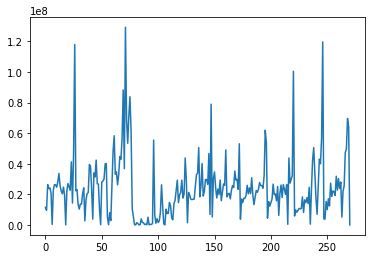

In [5]:
plt.plot(df1)

In [6]:
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [7]:
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size],df1[training_size:len(df1)]

In [8]:
len(train_data)

176

In [9]:
len(test_data)

95

In [10]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [11]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 50
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [12]:
print(X_train.shape), print(y_train.shape)
print(X_test.shape), print(ytest.shape)

(125, 50)
(125,)
(44, 50)
(44,)


(None, None)

In [13]:
# reshape input to be [samples, time steps, features] which is required for LSTM (3dimension)
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1) 
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [14]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from keras.callbacks import EarlyStopping

In [15]:
model=Sequential()
model.add(LSTM(30,return_sequences=True,input_shape=(50,1)))
#model.add(LSTM(100,return_sequences=True))
model.add(LSTM(10))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [16]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 30)            3840      
                                                                 
 lstm_1 (LSTM)               (None, 10)                1640      
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 5,491
Trainable params: 5,491
Non-trainable params: 0
_________________________________________________________________
None


In [17]:
early_stopping_monitor = EarlyStopping(monitor='loss',patience=3)
history = model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=30,batch_size=50,verbose=1,callbacks=[early_stopping_monitor])

Epoch 1/30
3/3 [==============================] - 5s 561ms/step - loss: 0.0669 - val_loss: 0.0625
Epoch 2/30
3/3 [==============================] - 0s 58ms/step - loss: 0.0504 - val_loss: 0.0466
Epoch 3/30
3/3 [==============================] - 0s 57ms/step - loss: 0.0371 - val_loss: 0.0349
Epoch 4/30
3/3 [==============================] - 0s 57ms/step - loss: 0.0293 - val_loss: 0.0287
Epoch 5/30
3/3 [==============================] - 0s 58ms/step - loss: 0.0282 - val_loss: 0.0286
Epoch 6/30
3/3 [==============================] - 0s 56ms/step - loss: 0.0291 - val_loss: 0.0287
Epoch 7/30
3/3 [==============================] - 0s 57ms/step - loss: 0.0285 - val_loss: 0.0282
Epoch 8/30
3/3 [==============================] - 0s 58ms/step - loss: 0.0272 - val_loss: 0.0281
Epoch 9/30
3/3 [==============================] - 0s 58ms/step - loss: 0.0262 - val_loss: 0.0284
Epoch 10/30
3/3 [==============================] - 0s 57ms/step - loss: 0.0259 - val_loss: 0.0289
Epoch 11/30
3/3 [===========

In [18]:
print(history.history.keys())

dict_keys(['loss', 'val_loss'])


In [19]:
from keras import backend as K
import tensorflow.compat.v1 as tf

curr_session = tf.get_default_session()
# close current session
if curr_session is not None:
    curr_session.close()
# reset graph
K.clear_session()
# create new session
s = tf.InteractiveSession()
K.set_session(s)

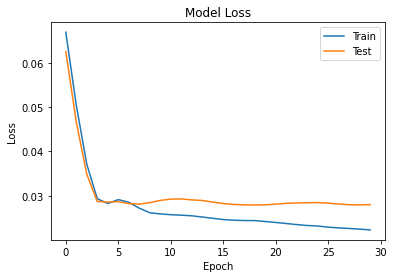

In [20]:
# Plot train vs test accuracy per epoch
plt.figure()
# Use the history metrics
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
# Make it pretty
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'])
plt.show()

In [21]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [22]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [23]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

25389970.795636974

In [24]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

24983282.09585338

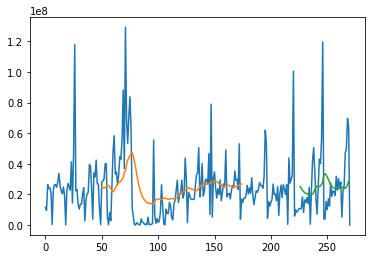

In [25]:
### Plotting 
# shift train predictions for plotting
look_back=50
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [26]:
len(test_data)

95

In [27]:
x_input=test_data[45:].reshape(1,-1)
x_input.shape

(1, 50)

In [28]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [29]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=50
i=0
while(i<30):
    if(len(temp_input)>50):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.24289405]
51
1 day input [7.58532346e-02 6.39521181e-02 7.25150720e-02 8.32632933e-02
 8.16481886e-02 8.31325076e-02 1.41871799e-01 6.29774984e-02
 1.26705887e-01 1.12552203e-01 1.37852749e-01 1.07948711e-01
 1.89979222e-01 3.73223581e-03 1.79687566e-01 3.27634022e-01
 3.91234384e-01 2.64350794e-01 1.34585116e-01 5.38009961e-02
 1.95686958e-01 3.32833741e-01 3.09361135e-01 4.39040318e-01
 9.25772929e-01 2.97818064e-02 2.94505182e-02 1.18902990e-01
 7.74595440e-02 1.32180219e-01 9.59159124e-02 2.11647897e-01
 1.43736020e-01 1.72048149e-01 1.67862677e-01 1.49108413e-01
 2.46300615e-01 1.76063401e-01 2.34415682e-01 1.84377710e-01
 2.17146924e-01 3.95291232e-02 1.69550776e-01 1.96973521e-01
 3.65765388e-01 3.84466025e-01 5.38523628e-01 4.94989116e-01
 1.44361596e-06 2.42894053e-01]
1 day output [[0.24227911]]
2 day input [6.39521181e-02 7.25150720e-02 8.32632933e-02 8.16481886e-02
 8.31325076e-02 1.41871799e-01 6.29774984e-02 1.26705887e-01
 1.12552203e-01 1.37852749e-01 1.07948711e-01 

12 day output [[0.21213084]]
13 day input [1.89979222e-01 3.73223581e-03 1.79687566e-01 3.27634022e-01
 3.91234384e-01 2.64350794e-01 1.34585116e-01 5.38009961e-02
 1.95686958e-01 3.32833741e-01 3.09361135e-01 4.39040318e-01
 9.25772929e-01 2.97818064e-02 2.94505182e-02 1.18902990e-01
 7.74595440e-02 1.32180219e-01 9.59159124e-02 2.11647897e-01
 1.43736020e-01 1.72048149e-01 1.67862677e-01 1.49108413e-01
 2.46300615e-01 1.76063401e-01 2.34415682e-01 1.84377710e-01
 2.17146924e-01 3.95291232e-02 1.69550776e-01 1.96973521e-01
 3.65765388e-01 3.84466025e-01 5.38523628e-01 4.94989116e-01
 1.44361596e-06 2.42894053e-01 2.42279112e-01 2.40133494e-01
 2.37167895e-01 2.33843625e-01 2.30444521e-01 2.27138937e-01
 2.24021494e-01 2.21139997e-01 2.18514174e-01 2.16144472e-01
 2.14021921e-01 2.12130845e-01]
13 day output [[0.210453]]
14 day input [3.73223581e-03 1.79687566e-01 3.27634022e-01 3.91234384e-01
 2.64350794e-01 1.34585116e-01 5.38009961e-02 1.95686958e-01
 3.32833741e-01 3.09361135e-01 4

26 day output [[0.2002762]]
27 day input [2.94505182e-02 1.18902990e-01 7.74595440e-02 1.32180219e-01
 9.59159124e-02 2.11647897e-01 1.43736020e-01 1.72048149e-01
 1.67862677e-01 1.49108413e-01 2.46300615e-01 1.76063401e-01
 2.34415682e-01 1.84377710e-01 2.17146924e-01 3.95291232e-02
 1.69550776e-01 1.96973521e-01 3.65765388e-01 3.84466025e-01
 5.38523628e-01 4.94989116e-01 1.44361596e-06 2.42894053e-01
 2.42279112e-01 2.40133494e-01 2.37167895e-01 2.33843625e-01
 2.30444521e-01 2.27138937e-01 2.24021494e-01 2.21139997e-01
 2.18514174e-01 2.16144472e-01 2.14021921e-01 2.12130845e-01
 2.10453004e-01 2.08968103e-01 2.07657635e-01 2.06501067e-01
 2.05480993e-01 2.04581469e-01 2.03788608e-01 2.03089058e-01
 2.02470988e-01 2.01923311e-01 2.01437294e-01 2.01005697e-01
 2.00621128e-01 2.00276196e-01]
27 day output [[0.19997224]]
28 day input [1.18902990e-01 7.74595440e-02 1.32180219e-01 9.59159124e-02
 2.11647897e-01 1.43736020e-01 1.72048149e-01 1.67862677e-01
 1.49108413e-01 2.46300615e-01 

In [30]:
day_new=np.arange(1,51)
day_pred=np.arange(51,81)

In [31]:
len(df1)-50

221

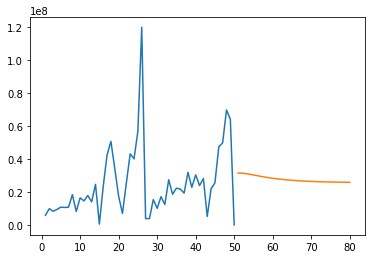

In [32]:
plt.plot(day_new,scaler.inverse_transform(df1[221:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

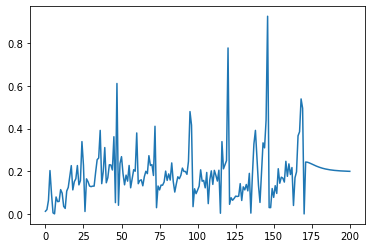

In [33]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[100:])

In [34]:
df3=scaler.inverse_transform(df3).tolist()

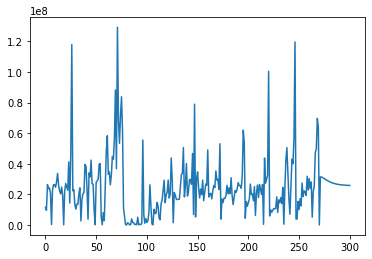

In [35]:
plt.plot(df3)